### Preparación de datos

#### Carga

In [2]:
import pandas as pd
from pathlib import Path
import re
# === RUTAS ===

ruta_acta =  Path(r"20251003/20251003/ADP_DTM_FACT.Acta.csv")
ruta_insumo =  Path(r"20251003/20251003/ADP_DTM_DIM.Insumo.csv")
ruta_proyectos =  Path(r"20251003/20251003/ADP_DTM_DIM.Proyecto.csv")
ruta_capitulos = Path(r"20251003/20251003/ADP_DTM_DIM.CapituloPresupuesto.csv")
ruta_proyeccion =  Path(r"20251003/20251003/ADP_DTM_FACT.Proyeccion.csv")
ruta_items =  Path(r"20251003/20251003/ADP_DTM_DIM.Items.csv")
ruta_macro = Path(r"20251003/20251003/proyectos_macroproyectos.csv")
tabla_macro = pd.read_csv(ruta_macro)


In [3]:
# === CARGA ===
tabla_proyeccion = pd.read_csv(ruta_proyeccion)
tabla_items = pd.read_csv(ruta_items)
tabla_proyectos = pd.read_csv(ruta_proyectos)
tabla_capitulos = pd.read_csv(ruta_capitulos)
tabla_insumos = pd.read_csv(ruta_insumo)
tabla_macro = pd.read_csv(ruta_macro)

C:\Users\aleja\AppData\Local\Temp\ipykernel_14580\1549343039.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  tabla_items = pd.read_csv(ruta_items)


#### New Join: (macroproyectos incluidos)

In [4]:
import pandas as pd

def add_table_suffix(dataframe: pd.DataFrame, table_tag: str, key_columns: list[str]) -> pd.DataFrame:
    """
    Renombra todas las columnas de 'dataframe' agregando sufijo '_table_tag',
    excepto las llaves de unión en 'key_columns'.
    """
    rename_map = {}
    for column in dataframe.columns:
        if column not in key_columns:
            rename_map[column] = f"{column}_{table_tag}"
    renamed = dataframe.rename(columns=rename_map)
    print(f"[DEBUG] add_table_suffix: '{table_tag}' -> {len(rename_map)} columnas renombradas.")
    return renamed

def merge_pipeline_with_suffix(
    tabla_proyeccion: pd.DataFrame,
    tabla_proyectos_macro: pd.DataFrame,
    tabla_capitulos: pd.DataFrame,
    tabla_items: pd.DataFrame,
    tabla_insumos: pd.DataFrame,
) -> pd.DataFrame:
    """
    Ejecuta el pipeline de merges asegurando que cada columna herede el sufijo de su tabla de origen.
    Las llaves de unión permanecen sin sufijo.
    """
    # Llaves de unión canónicas
    key_proyecto = "SkIdProyecto"
    key_capitulo = "SkIdCapitulo"
    key_item = "SkIdItems"
    key_insumo = "SkIdInsumo"

    # 1) Etiquetar cada tabla con su tag (solo columnas no-llave)
    proyeccion_tag = add_table_suffix(
        tabla_proyeccion.copy(), "Proyeccion", [key_proyecto, key_capitulo, key_item, key_insumo]
    )

    # Ojo: 'tabla_proyectos_macro' debería contener 'SkIdProyecto' tras su propio merge previo
    proyectos_macro_tag = add_table_suffix(
        tabla_proyectos_macro.copy(), "ProyectosMacro", [key_proyecto]
    )

    capitulos_tag = add_table_suffix(
        tabla_capitulos.copy(), "Capitulos", [key_capitulo]
    )

    # Asegurar unicidad en Items y etiquetar
    tabla_items_unica = tabla_items.drop_duplicates(subset=[key_item], keep="first").copy()
    items_tag = add_table_suffix(
        tabla_items_unica, "Items", [key_item]
    )

    # Asegurar unicidad en Insumos y etiquetar
    tabla_insumos_unica = tabla_insumos.drop_duplicates(subset=[key_insumo], keep="first").copy()
    insumos_tag = add_table_suffix(
        tabla_insumos_unica, "Insumos", [key_insumo]
    )

    # 2) Merges (las llaves permanecen limpias; el resto ya viene con sufijo)
    tabla_1 = pd.merge(proyeccion_tag, proyectos_macro_tag, on=key_proyecto, how="left")
    print(f"[DEBUG] Merge proyeccion + proyectos_macro => {tabla_1.shape}")

    tabla_2 = pd.merge(tabla_1, capitulos_tag, on=key_capitulo, how="left")
    print(f"[DEBUG] + capitulos => {tabla_2.shape}")

    tabla_3 = pd.merge(tabla_2, items_tag, on=key_item, how="left")
    print(f"[DEBUG] + items => {tabla_3.shape}")

    tabla_final = pd.merge(tabla_3, insumos_tag, on=key_insumo, how="left")
    print(f"[DEBUG] + insumos => {tabla_final.shape}")

    return tabla_final

# ===== Ejemplo con cero tecleo =====
# Si ya tienes las tablas en memoria con esos nombres, se saltará el demo.
need_demo = not all(name in globals() for name in [
    "tabla_proyeccion", "tabla_proyectos_macro", "tabla_capitulos", "tabla_items", "tabla_insumos"
])

if need_demo:
    print("[DEBUG] Cargando demo mínimo en memoria (se omitirá si ya existen tus DataFrames).")
    tabla_proyeccion = pd.DataFrame({
        "SkIdProyecto": [1, 1, 2],
        "SkIdCapitulo": [10, 10, 20],
        "SkIdItems": [100, 101, 200],
        "SkIdInsumo": [1000, 1001, 2000],
        "Cantidad": [5, 3, 7],
        "PrecioUnitario": [100, 200, 150],
    })

    tabla_proyectos_macro = pd.DataFrame({
        "SkIdProyecto": [1, 2],
        "Nombre Proyecto": ["Obra A", "Obra B"],
        "Proyecto_sin_prefijo": ["Obra A", "Obra B"],
        "Macroproyecto": ["MP Norte", "MP Sur"],
    })

    tabla_capitulos = pd.DataFrame({
        "SkIdCapitulo": [10, 20],
        "NombreCapitulo": ["Cimentación", "Estructura"],
    })

    tabla_items = pd.DataFrame({
        "SkIdItems": [100, 101, 200],
        "NombreItem": ["Excavación", "Encofrado", "Viga"],
        "Unidad": ["m3", "m2", "m"],
    })

    tabla_insumos = pd.DataFrame({
        "SkIdInsumo": [1000, 1001, 2000],
        "NombreInsumo": ["Concreto 3000", "Acero #4", "Concreto 3500"],
        "Proveedor": ["ProvA", "ProvB", "ProvA"],
    })

# Ejecutar pipeline
tabla_join = merge_pipeline_with_suffix(
    tabla_proyeccion, tabla_proyectos_macro, tabla_capitulos, tabla_items, tabla_insumos
)

print(f"[DEBUG] OK. Forma final: {tabla_join.shape}")
# Vista rápida: muestra algunas columnas clave + renombradas
muestra_cols = [c for c in tabla_join.columns if c.endswith("_ProyectosMacro") or c.endswith("_Items")]
muestra_cols = ["SkIdProyecto", "SkIdCapitulo", "SkIdItems", "SkIdInsumo"] + muestra_cols[:6]
print("[DEBUG] Muestra de columnas etiquetadas:")
print(tabla_join[muestra_cols].head())


[DEBUG] add_table_suffix: 'Proyeccion' -> 15 columnas renombradas.
[DEBUG] add_table_suffix: 'ProyectosMacro' -> 3 columnas renombradas.
[DEBUG] add_table_suffix: 'Capitulos' -> 7 columnas renombradas.
[DEBUG] add_table_suffix: 'Items' -> 22 columnas renombradas.
[DEBUG] add_table_suffix: 'Insumos' -> 23 columnas renombradas.
[DEBUG] Merge proyeccion + proyectos_macro => (273450, 22)
[DEBUG] + capitulos => (273450, 29)
[DEBUG] + items => (273450, 51)
[DEBUG] + insumos => (273450, 74)
[DEBUG] OK. Forma final: (273450, 74)
[DEBUG] Muestra de columnas etiquetadas:
   SkIdProyecto  SkIdCapitulo  SkIdItems  SkIdInsumo  \
0          1005       1005100    1006583      100279   
1          1005       1005100    1006583     1002087   
2          1005       1005100    1006583     1006063   
3          1005       1005100    1007643      100279   
4          1005       1005100    1007643     1002087   

  Nombre Proyecto_ProyectosMacro Proyecto_sin_prefijo_ProyectosMacro  \
0                      

In [6]:
## Vista de Concatenación Jerárquica
# Mostrar solo algunas columnas relevantes
columnas_mostrar = ["Macroproyecto", "Proyecto_sin_prefijo","Item Descripcion","Insumo_Insumo Descripcion"]
vista_concatenacion = tabla_join[columnas_mostrar]


KeyError: "None of [Index(['Macroproyecto', 'Proyecto_sin_prefijo', 'Item Descripcion',\n       'Insumo_Insumo Descripcion'],\n      dtype='object')] are in the [columns]"

### Verificación

In [5]:
# Vista rápida de verificación

# Obtener conjuntos únicos
set_macroproyectos = set(vista_concatenacion["Proyecto_sin_prefijo"].dropna().str.strip())
# Filtrar filas donde el campo 'Macroproyecto' está vacío o no coincide con los esperados
filtro_macro = vista_concatenacion[vista_concatenacion["Macroproyecto"].notna() | (vista_concatenacion["Macroproyecto"].str.strip() == "")]


display(filtro_macro[columnas_mostrar].head(10))

NameError: name 'vista_concatenacion' is not defined

In [13]:
tabla_join.shape


(273450, 114)

In [9]:
# === SELECCIÓN DE COLUMNAS ===
columnas_finales = [
    "SkIdProyecto", "SkIdCapitulo", "SkIdItems", "SkIdInsumo",
    "Nombre Proyecto", "Capitulo Descripcion", "Item Descripcion",
    "Insumo_Insumo Descripcion", "Insumo_Agrupacion Descripcion",
    "SkIdFecha Real", "Cantidad", "Valor Unitario", "Valor Total",
    "Insumo_Valor Unitario", "Insumo_Valor Neto", "Insumo_Fecha Creacion",
    "Cantidad Item", "Macroproyecto", "Insumo_Fecha Modificacion",
    "Fecha De Elaboracion", "Fecha De Inicio", "Fecha De Finalización",
    "SkIdFecha", "Capitulo Numero", "Cantidad_Item"
]

# Filtrar solo las columnas que existan realmente (por seguridad)
columnas_existentes = [col for col in columnas_finales if col in tabla_join.columns]
tabla_looker = tabla_join[columnas_existentes].copy()

print(f"[DEBUG] Columnas seleccionadas: {len(columnas_existentes)} / {len(columnas_finales)}")
print(f"[DEBUG] Forma final de tabla_looker: {tabla_looker.shape}")
display(tabla_looker.head(100))


[DEBUG] Columnas seleccionadas: 23 / 25
[DEBUG] Forma final de tabla_looker: (273450, 23)


,SkIdProyecto,SkIdCapitulo,SkIdItems,SkIdInsumo,Nombre Proyecto,Capitulo Descripcion,Item Descripcion,Insumo_Insumo Descripcion,Insumo_Agrupacion Descripcion,SkIdFecha Real,...,Insumo_Valor Unitario,Insumo_Valor Neto,Insumo_Fecha Creacion,Cantidad Item,Macroproyecto,Insumo_Fecha Modificacion,Fecha De Elaboracion,Fecha De Inicio,SkIdFecha,Capitulo Numero
0,1005,1005100,1006583,100279,URBAN PLAZA,CIMENTACION,Pilote preexcavado d=80cm,agua carrotanque,Campamento y provisionales,20110929,...,7327.59,8719.8321,06/12/2010,2.00,NaN,13/01/2011,28/03/2011,25/01/2011,20110929,2
1,1005,1005100,1006583,1002087,URBAN PLAZA,CIMENTACION,Pilote preexcavado d=80cm,concreto tremie 3000 psi grava común,Concretos Especiales,20110929,...,263115.84,313107.8496,06/12/2010,2.00,NaN,NaN,28/03/2011,25/01/2011,20110929,2
2,1005,1005100,1006583,1006063,URBAN PLAZA,CIMENTACION,Pilote preexcavado d=80cm,subcontrato pilote preexcavado d=0.80m,Subcontratos Preliminares Cimentación y Estruc...,20110929,...,40250.00,40250.0000,06/12/2010,2.00,NaN,27/05/2011,28/03/2011,25/01/2011,20110929,2
3,1005,1005100,1007643,100279,URBAN PLAZA,CIMENTACION,Pantalla preexcavada,agua carrotanque,Campamento y provisionales,20110930,...,7327.59,8719.8321,06/12/2010,32.28,NaN,13/01/2011,28/03/2011,25/01/2011,20110930,2
4,1005,1005100,1007643,1002087,URBAN PLAZA,CIMENTACION,Pantalla preexcavada,concreto tremie 3000 psi grava común,Concretos Especiales,20110930,...,263115.84,313107.8496,06/12/2010,32.28,NaN,NaN,28/03/2011,25/01/2011,20110930,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1005,1005102,1005464,1002329,URBAN PLAZA,ESTRUCTURA,Escalera en concreto - Zona subterranea,desmoldante (p),Desmoldantes y Curadores,20111021,...,7727.59,9195.8321,06/12/2010,22.34,NaN,NaN,28/03/2011,25/01/2011,20111021,4
96,1005,1005102,1005464,1002400,URBAN PLAZA,ESTRUCTURA,Escalera en concreto - Zona subterranea,distanciador silla mortero 25 mm,Accesorios Técnicos para Concreto,20111021,...,260.00,309.4000,06/12/2010,22.34,NaN,NaN,28/03/2011,25/01/2011,20111021,4
97,1005,1005102,1005464,1003845,URBAN PLAZA,ESTRUCTURA,Escalera en concreto - Zona subterranea,mano de obra estructura,Mano de Obra Estructura,20111021,...,2978.00,2978.0000,06/12/2010,22.34,NaN,26/05/2011,28/03/2011,25/01/2011,20111021,4
98,1005,1005102,1005464,1005022,URBAN PLAZA,ESTRUCTURA,Escalera en concreto - Zona subterranea,"puntilla con cabeza de 1-1/2"" a 4"" (p)",Demás Elementos de Ferretería,20111021,...,1350.00,1606.5000,06/12/2010,22.34,NaN,29/12/2022,28/03/2011,25/01/2011,20111021,4


#### Debug

In [9]:
# === MOSTRAR NOMBRES DE PROYECTOS Y MACROPROYECTOS ===

# Obtener listas únicas ordenadas
nombres_proyectos = sorted(tabla_proyectos["Nombre Proyecto"].dropna().unique().tolist())
nombres_macro = sorted(tabla_macro["Proyecto"].dropna().unique().tolist())

# Convertir a DataFrame comparativo
longitud_max = max(len(nombres_proyectos), len(nombres_macro))
tabla_comparativa = pd.DataFrame({
    "Nombre Proyecto (tabla_proyectos)": nombres_proyectos + [""] * (longitud_max - len(nombres_proyectos)),
    "Proyecto (proyectos_macroproyectos.csv)": nombres_macro + [""] * (longitud_max - len(nombres_macro))
})

print(f"[DEBUG] Proyectos en tabla_proyectos: {len(nombres_proyectos)}")
print(f"[DEBUG] Proyectos en proyectos_macroproyectos.csv: {len(nombres_macro)}")
print(f"[DEBUG] Mostrando tabla comparativa de nombres (orden alfabético)")

display(tabla_comparativa)


[DEBUG] Proyectos en tabla_proyectos: 85
[DEBUG] Proyectos en proyectos_macroproyectos.csv: 74
[DEBUG] Mostrando tabla comparativa de nombres (orden alfabético)


,Nombre Proyecto (tabla_proyectos),Proyecto (proyectos_macroproyectos.csv)
0,El Polo 1 - Etapa 1 - Torre 1,102 - Caminos de Sie - Urbanismo Externo MZ 2
1,ATRIO - Torre Norte,104 - Caminos de SIE - Edificaciones MZ2 - Et 1
2,BS Rosales,105 - Caminos de SIE - Edificaciones MZ2 - Et 2
3,CC Atrio - Circundantes Plaza Cívica,106 - Caminos de SIE - Edificaciones MZ2 - Et 3
4,CC Atrio - Plaza Cívica,107 - Caminos de SIE - Edificaciones MZ2 - Et 4
...,...,...
80,Valverde - Etapa Menta,
81,Valverde - Etapa Olivo,
82,Valverde - Palma,
83,Valverde - Roble,


#### quitar prefijo para ajustar nombres de macroproyectos

In [4]:
# === COMPARAR NOMBRES LIMPIOS DE MACROPROYECTOS VS tabla_proyectos ===
import pandas as pd
import re

def quitar_prefijo_numero(nombre: str) -> str:
    if pd.isna(nombre):
        return ""
    return re.sub(r"^\s*\d+\s*-\s*", "", str(nombre)).strip()

# Crear columna limpia en la tabla de macroproyectos
tabla_macro["Proyecto_sin_prefijo"] = tabla_macro["Proyecto"].apply(quitar_prefijo_numero)

# Obtener conjuntos únicos
set_proyectos = set(tabla_proyectos["Nombre Proyecto"].dropna().str.strip())
set_macro_limpio = set(tabla_macro["Proyecto_sin_prefijo"].dropna().str.strip())

# Calcular intersección y diferencias
interseccion = set_proyectos.intersection(set_macro_limpio)
faltantes_en_macro = set_proyectos - set_macro_limpio
faltantes_en_proyectos = set_macro_limpio - set_proyectos

print(f"[DEBUG] Coincidencias exactas (sin prefijo): {len(interseccion)}")
print(f"[DEBUG] Faltan en macroproyectos.csv (aun después de limpiar): {len(faltantes_en_macro)}")
print(f"[DEBUG] Faltan en tabla_proyectos: {len(faltantes_en_proyectos)}")

# Mostrar ejemplos de ambos
print("\n[DEBUG] Ejemplos de coincidencias:")
print(sorted(list(interseccion))[:5])

print("\n[DEBUG] Ejemplos de proyectos que faltan en macroproyectos:")
print(sorted(list(faltantes_en_macro))[:5])

print("\n[DEBUG] Ejemplos de proyectos que faltan en tabla_proyectos:")
print(sorted(list(faltantes_en_proyectos))[:5])


[DEBUG] Coincidencias exactas (sin prefijo): 67
[DEBUG] Faltan en macroproyectos.csv (aun después de limpiar): 18
[DEBUG] Faltan en tabla_proyectos: 7

[DEBUG] Ejemplos de coincidencias:
['BS Rosales', 'Caminos de SIE - Edificaciones MZ 4', 'Caminos de Sie - Edificaciones MZ1 - Et 1', 'Caminos de Sie - Edificaciones MZ1 - Et 2', 'Caminos de Sie - Edificaciones MZ1 - Et 3']

[DEBUG] Ejemplos de proyectos que faltan en macroproyectos:
['ATRIO - Torre Norte', 'CC Atrio - Circundantes Plaza Cívica', 'CC Atrio - Plaza Cívica', 'Caminos de Sie - Urbanismo Externo', 'Centro Cultural Atrio - Etapa 1']

[DEBUG] Ejemplos de proyectos que faltan en tabla_proyectos:
['Caminos de SIE - Edificaciones MZ2 - Et 1', 'Caminos de SIE - Edificaciones MZ2 - Et 2', 'Caminos de SIE - Edificaciones MZ2 - Et 3', 'Caminos de SIE - Edificaciones MZ2 - Et 4', 'Caminos de Sie - Urbanismo Externo MZ 2']


In [22]:
import re

if "Nombre Proyecto" in tabla_looker.columns and "Proyecto_sin_prefijo" not in tabla_looker.columns:
    tabla_looker["Proyecto_sin_prefijo"] = tabla_looker["Nombre Proyecto"].apply(
        lambda x: re.sub(r"^\s*\d+\s*-\s*", "", str(x)).strip() if pd.notna(x) else x
    )
    print("[DEBUG] Columna 'Proyecto_sin_prefijo' creada en tabla_looker.")

[DEBUG] Columna 'Proyecto_sin_prefijo' creada en tabla_looker.


## Revisión fechas proyecto

### revisión formato

In [15]:
# Filtra columnas que contengan 'fecha' (sin importar mayúsculas o acentos)
cols_fecha_proy = [c for c in tabla_proyectos.columns if "fecha" in c.lower()]

print("[DEBUG] Columnas de fecha encontradas en tabla_proyectos:")
print(cols_fecha_proy)

# Muestra tipos y algunos ejemplos para revisar formato
if cols_fecha_proy:
    print("\n[DEBUG] Tipos de datos:")
    print(tabla_proyectos[cols_fecha_proy].dtypes)

    print("\n[DEBUG] Ejemplos (primeras 5 no nulas por columna):")
    for col in cols_fecha_proy:
        muestra = tabla_proyectos[col].dropna().astype(str).head(5).tolist()
        print(f"  {col}: {muestra}")
else:
    print("[DEBUG] No se encontraron columnas que contengan la palabra 'fecha'.")


[DEBUG] Columnas de fecha encontradas en tabla_proyectos:
['Fecha De Elaboracion', 'Fecha De Inicio', 'Fecha De Finalizacion']

[DEBUG] Tipos de datos:
Fecha De Elaboracion     object
Fecha De Inicio          object
Fecha De Finalizacion    object
dtype: object

[DEBUG] Ejemplos (primeras 5 no nulas por columna):
  Fecha De Elaboracion: ['28/02/2011', '28/03/2011', '24/02/2011', '15/07/2011', '15/07/2011']
  Fecha De Inicio: ['17/01/2011', '25/01/2011', '02/05/2011', '15/07/2011', '15/07/2011']
  Fecha De Finalizacion: ['21/12/2012', '25/03/2013', '24/02/2012', '15/06/2013', '31/12/2013']


### visualización

#### 2

[DEBUG] Construyendo DF para timeline (Proyecto: Elaboración, Inicio, Fin)
[DEBUG] Filas válidas para timeline: 85 (descartadas: 0)
[DEBUG] Graficando Gantt con marcas de Elaboración...


C:\Users\aleja\AppData\Local\Temp\ipykernel_14580\2975520151.py:123: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aleja\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


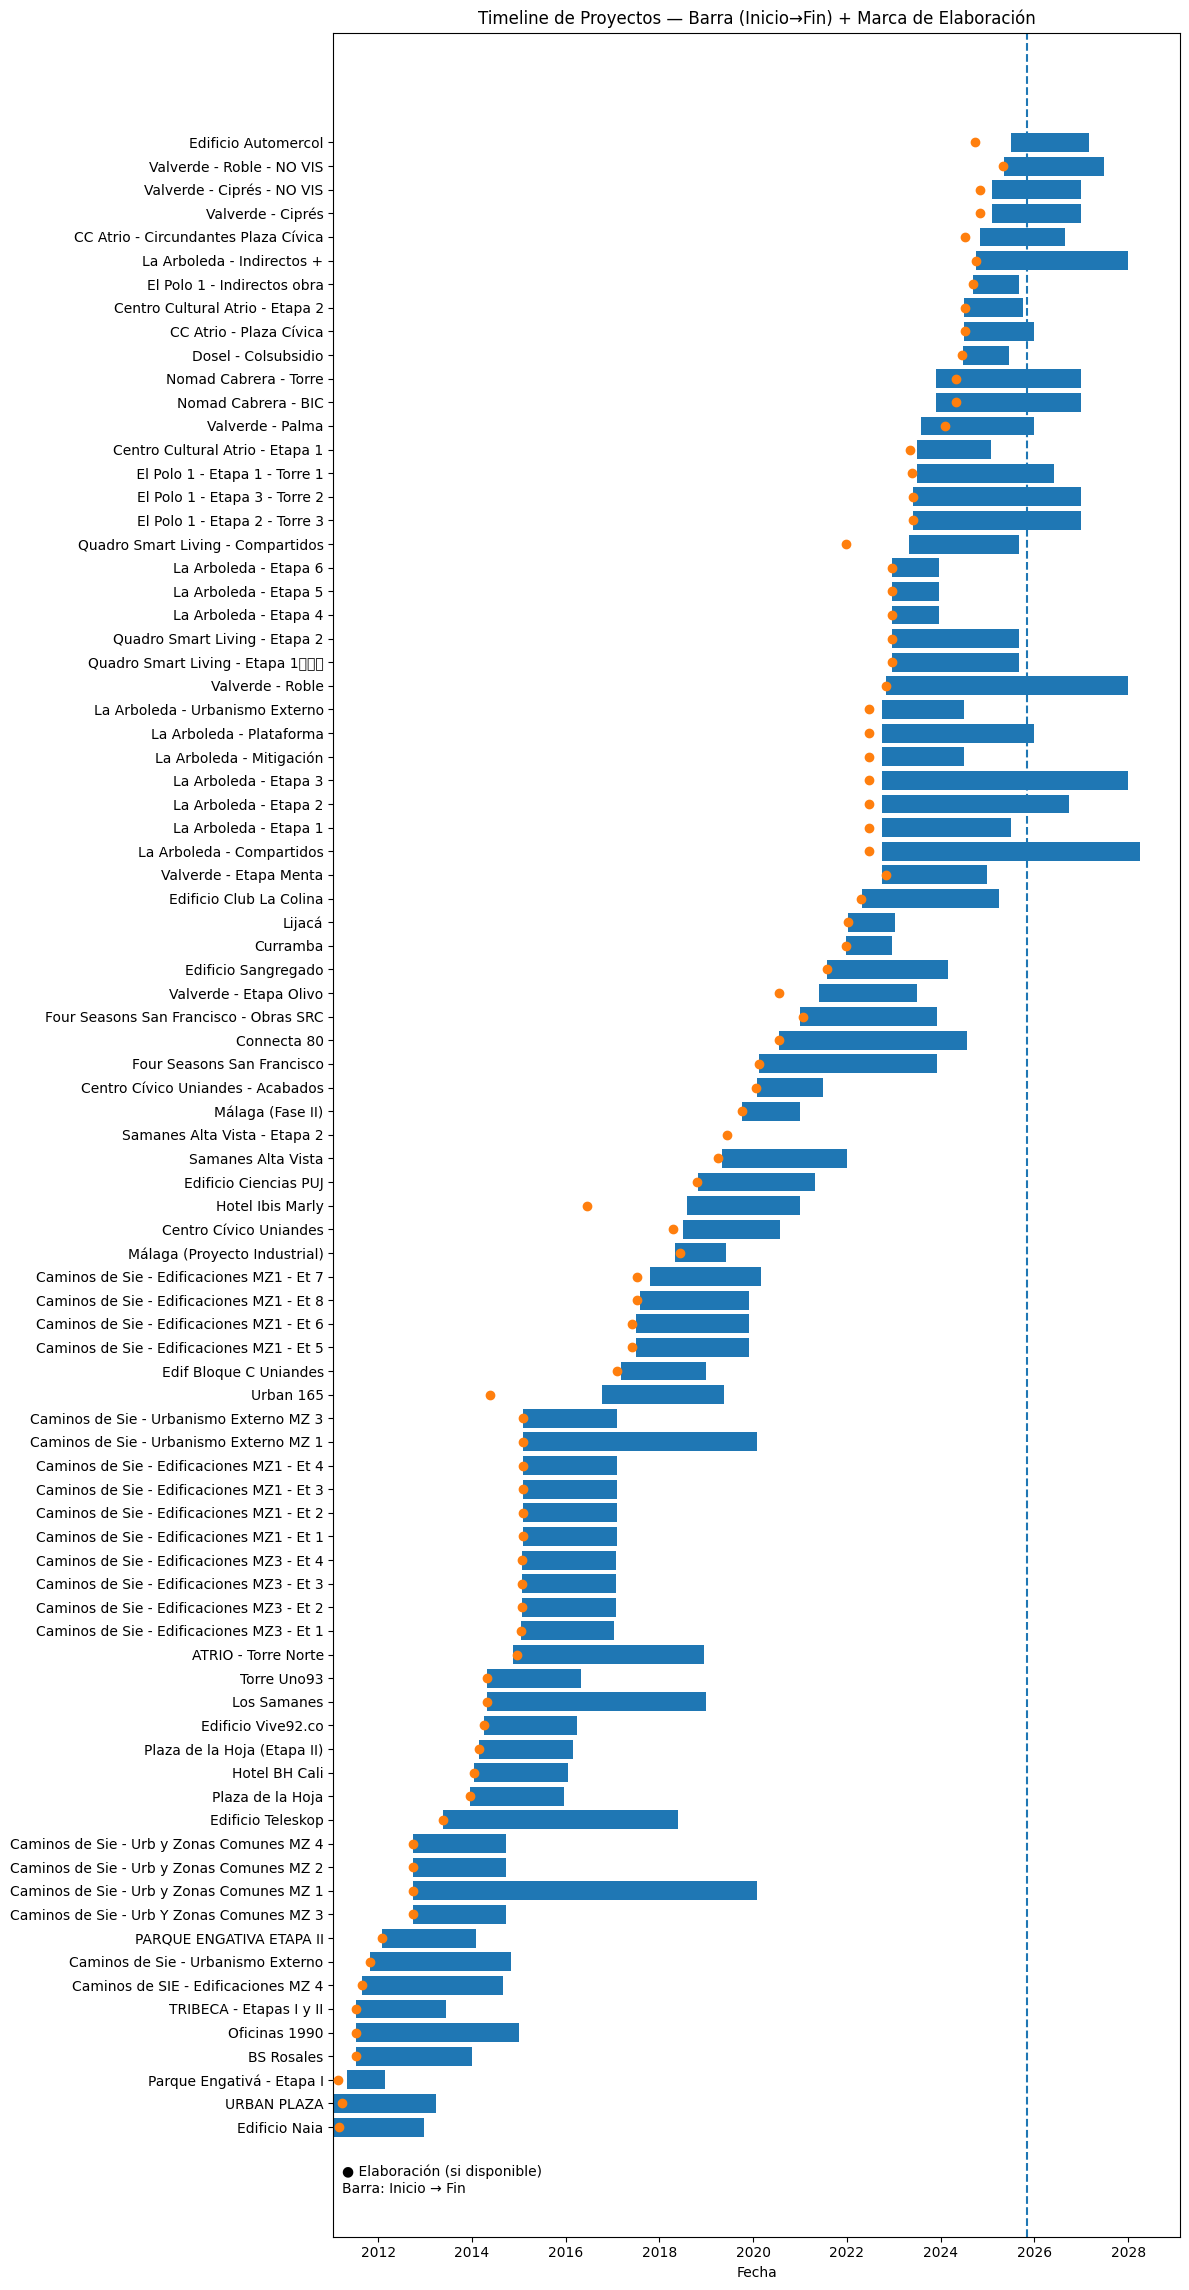

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============== Helpers =================
def pick_first_col(dataframe: pd.DataFrame, candidates: list[str]) -> str | None:
    for name in candidates:
        if name in dataframe.columns:
            return name
    # búsqueda flexible por minúsculas
    lower_map = {c.lower(): c for c in dataframe.columns}
    for name in candidates:
        if name.lower() in lower_map:
            return lower_map[name.lower()]
    return None

def to_datetime_series(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", dayfirst=True)

# ============== Construcción DF timeline ==============
def build_timeline_proyectos(tabla_proyectos: pd.DataFrame) -> pd.DataFrame:
    print("[DEBUG] Construyendo DF para timeline (Proyecto: Elaboración, Inicio, Fin)")

    col_proyecto = pick_first_col(tabla_proyectos, [
        "Nombre Proyecto","Proyecto","Nombre_Proyecto","Nombre Proyecto_ProyectosMacro","NombreProyecto"
    ]) or "SkIdProyecto"  # fallback id si no hay nombre

    col_elab = pick_first_col(tabla_proyectos, [
        "Fecha De Elaboracion","Fecha Elaboracion","Fecha de Elaboracion","Fecha Elaboración","Fecha_Elaboracion"
    ])
    col_inicio = pick_first_col(tabla_proyectos, [
        "Fecha De Inicio","Fecha Inicio","Fecha de Inicio","Fecha_Inicio","Fecha Inicio Proyecto"
    ])
    col_fin = pick_first_col(tabla_proyectos, [
        "Fecha De Finalizacion","Fecha Final","Fecha de Finalizacion","Fecha_Final","Fecha Fin","Fecha de Finalización"
    ])

    if col_inicio is None:
        raise KeyError("No se encontró columna de fecha de inicio en tabla_proyectos.")
    if col_elab is None:
        print("[DEBUG] No se encontró 'Fecha de Elaboración'; se omitirá la marca de elaboración.")
    if col_fin is None:
        print("[DEBUG] No se encontró fecha de fin; se usará Inicio como fin (barra mínima).")

    cols = [col_proyecto, col_elab, col_inicio, col_fin]
    cols_existing = [c for c in cols if c is not None]
    df = tabla_proyectos[cols_existing].copy()

    # Normaliza nombres estándar
    rename_map = {}
    rename_map[col_proyecto] = "proyecto"
    if col_elab is not None: rename_map[col_elab] = "fecha_elaboracion"
    rename_map[col_inicio] = "fecha_inicio"
    if col_fin is not None: rename_map[col_fin] = "fecha_fin"
    df.rename(columns=rename_map, inplace=True)

    # Convertir a datetime
    df["fecha_inicio"] = to_datetime_series(df["fecha_inicio"])
    if "fecha_fin" in df.columns:
        df["fecha_fin"] = to_datetime_series(df["fecha_fin"])
    else:
        df["fecha_fin"] = pd.NaT
    if "fecha_elaboracion" in df.columns:
        df["fecha_elaboracion"] = to_datetime_series(df["fecha_elaboracion"])

    # Completar fin faltante con inicio
    mask_fin_nat = df["fecha_fin"].isna() & df["fecha_inicio"].notna()
    if mask_fin_nat.any():
        df.loc[mask_fin_nat, "fecha_fin"] = df.loc[mask_fin_nat, "fecha_inicio"]
        print(f"[DEBUG] {mask_fin_nat.sum()} filas sin fecha_fin: se asignó fecha_inicio como fin.")

    # Filtrar válidas (necesitamos al menos inicio)
    before = len(df)
    df = df.dropna(subset=["fecha_inicio"]).copy()
    print(f"[DEBUG] Filas válidas para timeline: {len(df)} (descartadas: {before - len(df)})")

    # Orden por inicio luego nombre
    df = df.sort_values(["fecha_inicio", "proyecto"]).reset_index(drop=True)
    return df

# ============== Plot (barra Inicio-Fin + marca Elaboración) ==============
def plot_timeline_con_elaboracion(df_tl: pd.DataFrame):
    if df_tl.empty:
        print("[DEBUG] DataFrame vacío; no hay nada que graficar.")
        return

    print("[DEBUG] Graficando Gantt con marcas de Elaboración...")
    # Duración (>=1 día para visualizar)
    duracion_dias = (df_tl["fecha_fin"] - df_tl["fecha_inicio"]).dt.days.clip(lower=1)

    y_pos = np.arange(len(df_tl))
    fig_h = max(6, int(len(df_tl) * 0.28))

    plt.figure(figsize=(12, fig_h))
    # Barras inicio-fin
    plt.barh(y_pos, duracion_dias, left=df_tl["fecha_inicio"])

    # Marcas de elaboración (si existe la columna)
    if "fecha_elaboracion" in df_tl.columns:
        mask_elab = df_tl["fecha_elaboracion"].notna()
        if mask_elab.any():
            # Dibujamos como puntos sobre la misma línea y
            plt.scatter(
                df_tl.loc[mask_elab, "fecha_elaboracion"],
                y_pos[mask_elab.values],
                marker="o",
                zorder=3
            )

    # Eje y y etiquetas
    plt.yticks(y_pos, df_tl["proyecto"].astype(str).tolist())
    plt.xlabel("Fecha")
    plt.title("Timeline de Proyectos — Barra (Inicio→Fin) + Marca de Elaboración")

    # Línea de 'hoy'
    hoy = pd.Timestamp.today().normalize()
    plt.axvline(hoy, linestyle="--")

    # Leyenda sencilla (texto)
    leyenda = "● Elaboración (si disponible)\nBarra: Inicio → Fin"
    plt.text(0.01, 0.02, leyenda, transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

# ============== EJECUCIÓN (cero tecleo) ==============
try:
    gantt_df = build_timeline_proyectos(tabla_proyectos)
    plot_timeline_con_elaboracion(gantt_df)
except Exception as e:
    print(f"[DEBUG] Error: {e}")


# Intersecciones

### 1

In [11]:
import pandas as pd

def normalizar_texto(serie: pd.Series) -> pd.Series:
    serie = serie.astype(str).fillna("").str.strip()
    return serie.str.replace(r"\s+", " ", regex=True).str.lower()

def coalesce_proyecto(dataframe: pd.DataFrame) -> pd.Series:
    """
    Devuelve una serie con el nombre de proyecto 'resuelto' coalesciendo entre columnas candidatas,
    en este orden de prioridad. Si todas fallan, usa SkIdProyecto como string.
    """
    candidatos = [
        "Nombre Proyecto_ProyectosMacro",
        "Proyecto_sin_prefijo_ProyectosMacro",
        "Codigo Proyecto_Capitulos",
    ]
    if "SkIdProyecto" not in dataframe.columns:
        raise KeyError("Falta 'SkIdProyecto' para fallback.")

    # arranca vacío
    res = pd.Series([""] * len(dataframe), index=dataframe.index, dtype="object")

    usados = []
    for col in candidatos:
        if col in dataframe.columns:
            mask = (res == "") & dataframe[col].notna() & (dataframe[col].astype(str).str.strip() != "")
            res.loc[mask] = dataframe.loc[mask, col].astype(str)
            usados.append(col)

    # fallback final
    mask_faltantes = (res == "")
    if mask_faltantes.any():
        res.loc[mask_faltantes] = dataframe.loc[mask_faltantes, "SkIdProyecto"].astype(str)
        usados.append("SkIdProyecto [fallback]")

    print(f"[DEBUG] Columnas consideradas para nombre de proyecto (en orden): {candidatos} + fallback")
    print(f"[DEBUG] Fallback aplicado en {mask_faltantes.sum()} filas.")
    return res

def construir_tabla_unicos_por_proyecto_resuelto(
    dataframe: pd.DataFrame,
    columna_capitulo: str = "Capitulo Descripcion_Capitulos",
) -> pd.DataFrame:
    if columna_capitulo not in dataframe.columns:
        raise KeyError(f"Falta la columna de capítulos: '{columna_capitulo}'")

    # Construye el nombre de proyecto resuelto
    serie_proyecto_resuelto = coalesce_proyecto(dataframe)
    df = pd.DataFrame({
        "_proyecto_raw": serie_proyecto_resuelto,
        columna_capitulo: dataframe[columna_capitulo],
    }).copy()

    # Normaliza para comparar robustamente
    df["_proyecto_norm"] = normalizar_texto(df["_proyecto_raw"])
    df["_capitulo_norm"] = normalizar_texto(df[columna_capitulo])

    # Filas válidas: ambas no vacías tras limpieza
    mask_valid = (df["_proyecto_norm"] != "") & (df["_capitulo_norm"] != "")
    print(f"[DEBUG] Filas totales: {len(df)} | válidas (ambas no vacías): {mask_valid.sum()}")

    if mask_valid.sum() == 0:
        print("[DEBUG] No hay filas válidas; revisa columnas o merges.")
        return pd.DataFrame(columns=[
            "Nombre Proyecto",
            "cantidad_valores_unicos_nuevos",
            "cantidad_valores_unicos_totales_hasta_este_proyecto",
        ])

    # Nombre representativo por proyecto (mínimo lexicográfico del raw no normalizado)
    nombre_representativo = (
        df.loc[mask_valid]
          .groupby("_proyecto_norm")["_proyecto_raw"]
          .agg(lambda s: sorted(set(s))[0])
          .rename("Nombre Proyecto")
          .reset_index()
    )

    # Conjunto de capítulos únicos por proyecto
    capitulos_por_proyecto = (
        df.loc[mask_valid]
          .groupby("_proyecto_norm")["_capitulo_norm"]
          .apply(lambda s: set(s.unique()))
          .rename("conjunto_capitulos")
          .reset_index()
    )

    # Orden alfabético por el nombre normalizado
    tabla = (
        capitulos_por_proyecto.merge(nombre_representativo, on="_proyecto_norm", how="left")
        .sort_values("_proyecto_norm", kind="mergesort")
        .reset_index(drop=True)
    )

    # Recorre y acumula
    capitulos_vistos = set()
    nuevos_list = []
    acumulado_list = []
    for _, fila in tabla.iterrows():
        nuevos = fila["conjunto_capitulos"] - capitulos_vistos
        capitulos_vistos.update(fila["conjunto_capitulos"])
        nuevos_list.append(len(nuevos))
        acumulado_list.append(len(capitulos_vistos))
        print(f"[DEBUG] Proyecto='{fila['Nombre Proyecto']}' | nuevos={len(nuevos)} | acumulado={len(capitulos_vistos)}")

    resultado = pd.DataFrame({
        "Nombre Proyecto": tabla["Nombre Proyecto"],
        "cantidad_valores_unicos_nuevos": nuevos_list,
        "cantidad_valores_unicos_totales_hasta_este_proyecto": acumulado_list,
    })
    return resultado

# ===== Ejecutar (cero tecleo) =====
try:
    tabla_unicos = construir_tabla_unicos_por_proyecto_resuelto(
        dataframe=tabla_join,
        columna_capitulo="Capitulo Descripcion_Capitulos",
    )
    try:
        from IPython.display import display
        display(tabla_unicos)
    except Exception:
        print(tabla_unicos.to_string(index=False))
except Exception as e:
    print(f"[DEBUG] Error: {e}")


[DEBUG] Columnas consideradas para nombre de proyecto (en orden): ['Nombre Proyecto_ProyectosMacro', 'Proyecto_sin_prefijo_ProyectosMacro', 'Codigo Proyecto_Capitulos'] + fallback
[DEBUG] Fallback aplicado en 0 filas.
[DEBUG] Filas totales: 273450 | válidas (ambas no vacías): 273450
[DEBUG] Proyecto='108' | nuevos=29 | acumulado=29
[DEBUG] Proyecto='11' | nuevos=3 | acumulado=32
[DEBUG] Proyecto='111' | nuevos=0 | acumulado=32
[DEBUG] Proyecto='115' | nuevos=0 | acumulado=32
[DEBUG] Proyecto='116' | nuevos=0 | acumulado=32
[DEBUG] Proyecto='117' | nuevos=1 | acumulado=33
[DEBUG] Proyecto='118' | nuevos=0 | acumulado=33
[DEBUG] Proyecto='12' | nuevos=0 | acumulado=33
[DEBUG] Proyecto='127' | nuevos=0 | acumulado=33
[DEBUG] Proyecto='128' | nuevos=0 | acumulado=33
[DEBUG] Proyecto='129' | nuevos=0 | acumulado=33
[DEBUG] Proyecto='13' | nuevos=1 | acumulado=34
[DEBUG] Proyecto='130' | nuevos=0 | acumulado=34
[DEBUG] Proyecto='131' | nuevos=0 | acumulado=34
[DEBUG] Proyecto='132' | nuevos=

,Nombre Proyecto,cantidad_valores_unicos_nuevos,cantidad_valores_unicos_totales_hasta_este_proyecto
0,108,29,29
1,11,3,32
2,111,0,32
3,115,0,32
4,116,0,32
...,...,...,...
71,31,0,157
72,35,0,157
73,5,0,157
74,6,0,157


### 2

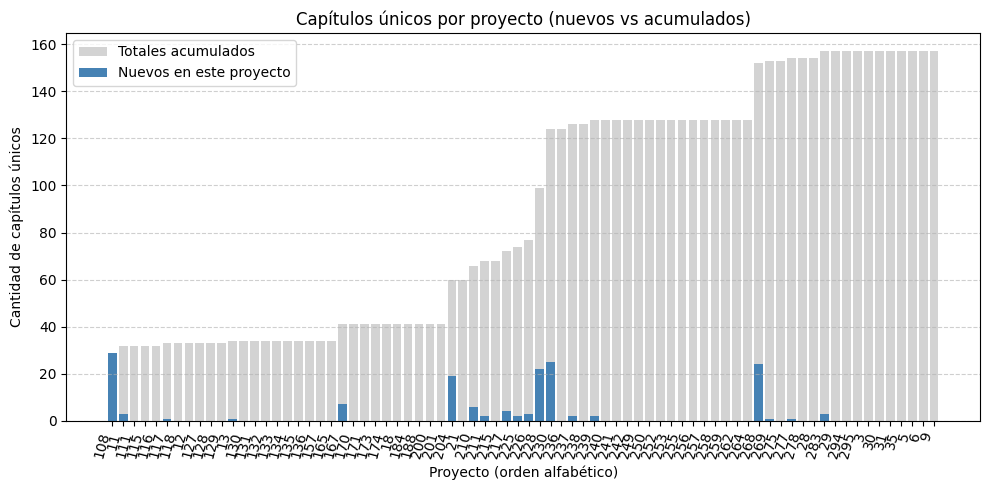

In [12]:
import matplotlib.pyplot as plt

# Asegúrate de que la tabla ya exista
if "tabla_unicos" not in globals() or tabla_unicos.empty:
    print("[DEBUG] No se encontró 'tabla_unicos' en memoria o está vacía.")
else:
    plt.figure(figsize=(10,5))
    plt.bar(
        tabla_unicos["Nombre Proyecto"],
        tabla_unicos["cantidad_valores_unicos_totales_hasta_este_proyecto"],
        label="Totales acumulados",
        color="lightgray"
    )
    plt.bar(
        tabla_unicos["Nombre Proyecto"],
        tabla_unicos["cantidad_valores_unicos_nuevos"],
        label="Nuevos en este proyecto",
        color="steelblue"
    )

    plt.title("Capítulos únicos por proyecto (nuevos vs acumulados)")
    plt.xlabel("Proyecto (orden alfabético)")
    plt.ylabel("Cantidad de capítulos únicos")
    plt.xticks(rotation=75, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


#### debug

In [8]:
print("\n".join(sorted(tabla_join.columns)))


Agrupacion Descripcion_Insumos
Agrupacion_Insumos
Ajuste Global_Proyeccion
Aplica En Almacen_Items
Aplica En Contratos_Items
Bloqueo De Contratos Por Cantidad_Items
Bloqueo De Contratos Por Valor_Items
Bloqueo De Salidas Por Cantidad_Items
Bloqueo De Salidas Por Valor_Items
Cantidad Item_Proyeccion
Cantidad Proyectada_Items
Cantidad_Items
Cantidad_Proyeccion
Capitulo Descripcion_Capitulos
Capitulo Numero_Capitulos
Causa_Proyeccion
Clase Item_Items
Codigo Cliente_Items
Codigo Insumo Id_Insumos
Codigo Insumo_Insumos
Codigo Proyecto_Capitulos
Descripcion Causa_Proyeccion
Descripcion Unidad_Insumos
Devolutivo_Insumos
Dias Reposicion_Insumos
Empresa_Capitulos
Empresa_Insumos
Empresa_Items
Empresa_Proyeccion
Estado_Insumos
Fecha Creacion_Insumos
Fecha Modificacion_Insumos
Insumo Descripcion_Insumos
Item Descripcion_Items
Item No_Items
Item estado_Items
Macroproyecto_ProyectosMacro
Metro cuadrado_Items
Nombre Proyecto_ProyectosMacro
Origen_Proyeccion
Porcentaje IVA_Insumos
Precio Venta_Items


# CONCATENAR DESCRIPCIONES JERÁRQUICAS Y MOSTRAR MUESTRA

#### Concatenar

In [22]:
# === CONCATENAR DESCRIPCIONES JERÁRQUICAS Y MOSTRAR MUESTRA ===

import pandas as pd

def construir_descripcion_jerarquica(fila: pd.Series,
                                     columnas_a_concatenar: list[str],
                                     separador: str = " - ") -> str:
    partes_limpias: list[str] = []
    for nombre_columna in columnas_a_concatenar:
        valor = fila.get(nombre_columna, "")
        if pd.isna(valor):
            continue
        valor_str = str(valor).strip()
        if valor_str:
            partes_limpias.append(valor_str)
    return separador.join(partes_limpias)

columnas_objetivo: list[str] = [
    "Macroproyecto",
    "Proyecto_sin_prefijo",
    "Capitulo Descripcion",
    "Item Descripcion",
    "Insumo_Insumo Descripcion",
]

columnas_que_existen = [c for c in columnas_objetivo if c in tabla_join.columns]
columnas_que_faltan = [c for c in columnas_objetivo if c not in tabla_join.columns]

print(f"[DEBUG] Columnas objetivo: {columnas_objetivo}")
print(f"[DEBUG] Columnas encontradas en 'tabla_join': {columnas_que_existen}")
if columnas_que_faltan:
    print(f"[DEBUG] ADVERTENCIA: Faltan estas columnas y se omitirán: {columnas_que_faltan}")

nombre_columna_salida = "Descripcion_Jerarquica"
vista_concatenacion[nombre_columna_salida] = vista_concatenacion.apply(
    construir_descripcion_jerarquica,
    axis=1,
    columnas_a_concatenar=columnas_que_existen,
    separador=" - "
)





[DEBUG] Columnas objetivo: ['Macroproyecto', 'Proyecto_sin_prefijo', 'Capitulo Descripcion', 'Item Descripcion', 'Insumo_Insumo Descripcion']
[DEBUG] Columnas encontradas en 'tabla_join': ['Macroproyecto', 'Proyecto_sin_prefijo', 'Capitulo Descripcion', 'Item Descripcion', 'Insumo_Insumo Descripcion']


C:\Users\aleja\AppData\Local\Temp\ipykernel_26056\3746829230.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vista_concatenacion[nombre_columna_salida] = vista_concatenacion.apply(


In [23]:
# Vista rápida de verificación
#display(tabla_final[["Nombre Proyecto", "Macroproyecto"]].head(10))

# Obtener conjuntos únicos
set_macroproyectos = set(tabla_join["Proyecto_sin_prefijo"].dropna().str.strip())
# Filtrar filas donde el campo 'Macroproyecto' está vacío o no coincide con los esperados
filtro_no_macro = tabla_join[tabla_join["Macroproyecto"].notna() | (tabla_join["Macroproyecto"].str.strip() == "")]

# Mostrar solo algunas columnas relevantes
columnas_mostrar = ["Nombre Proyecto", "Macroproyecto", "Proyecto_sin_prefijo", "SkIdProyecto", "SkIdCapitulo"]
display(filtro_no_macro[columnas_mostrar].head(10))

,Nombre Proyecto,Macroproyecto,Proyecto_sin_prefijo,SkIdProyecto,SkIdCapitulo
10273,Caminos de Sie - Urb y Zonas Comunes MZ 4,Caminos de Sie - Manzana 4,Caminos de Sie - Urb y Zonas Comunes MZ 4,10028,10028576
10274,Caminos de Sie - Urb y Zonas Comunes MZ 4,Caminos de Sie - Manzana 4,Caminos de Sie - Urb y Zonas Comunes MZ 4,10028,10028576
10275,Caminos de Sie - Urb y Zonas Comunes MZ 4,Caminos de Sie - Manzana 4,Caminos de Sie - Urb y Zonas Comunes MZ 4,10028,10028576
10276,Caminos de Sie - Urb y Zonas Comunes MZ 4,Caminos de Sie - Manzana 4,Caminos de Sie - Urb y Zonas Comunes MZ 4,10028,10028576
10277,Caminos de Sie - Urb y Zonas Comunes MZ 4,Caminos de Sie - Manzana 4,Caminos de Sie - Urb y Zonas Comunes MZ 4,10028,10028576
12252,Caminos de Sie - Urb y Zonas Comunes MZ 4,Caminos de Sie - Manzana 4,Caminos de Sie - Urb y Zonas Comunes MZ 4,10028,10028603
12358,Caminos de SIE - Edificaciones MZ 4,Caminos de Sie - Manzana 4,Caminos de SIE - Edificaciones MZ 4,10013,10013289
12359,Caminos de SIE - Edificaciones MZ 4,Caminos de Sie - Manzana 4,Caminos de SIE - Edificaciones MZ 4,10013,10013289
12360,Caminos de SIE - Edificaciones MZ 4,Caminos de Sie - Manzana 4,Caminos de SIE - Edificaciones MZ 4,10013,10013289
12361,Caminos de SIE - Edificaciones MZ 4,Caminos de Sie - Manzana 4,Caminos de SIE - Edificaciones MZ 4,10013,10013289


In [24]:
# Mostrar solo filas con Macroproyecto definido
tamano_muestra: int = 100
muestra_pequena = (
    vista_concatenacion[
        vista_concatenacion["Macroproyecto"].notna()
        & (vista_concatenacion["Macroproyecto"].astype(str).str.strip() != "")
    ][[nombre_columna_salida]]
    .head(tamano_muestra)
)

print(f"[DEBUG] Tamaño de la tabla con la nueva columna: {vista_concatenacion.shape}")
print(f"[DEBUG] Mostrando las primeras {tamano_muestra} filas que tienen Macroproyecto definido:")
display(muestra_pequena)

[DEBUG] Tamaño de la tabla con la nueva columna: (273450, 5)
[DEBUG] Mostrando las primeras 100 filas que tienen Macroproyecto definido:


,Descripcion_Jerarquica
10273,Caminos de Sie - Manzana 4 - Caminos de Sie - ...
10274,Caminos de Sie - Manzana 4 - Caminos de Sie - ...
10275,Caminos de Sie - Manzana 4 - Caminos de Sie - ...
10276,Caminos de Sie - Manzana 4 - Caminos de Sie - ...
10277,Caminos de Sie - Manzana 4 - Caminos de Sie - ...
...,...
12477,Caminos de Sie - Manzana 4 - Caminos de SIE - ...
12478,Caminos de Sie - Manzana 4 - Caminos de SIE - ...
12479,Caminos de Sie - Manzana 4 - Caminos de SIE - ...
12480,Caminos de Sie - Manzana 4 - Caminos de SIE - ...


#### debug

In [28]:
# === DIAGNÓSTICO RÁPIDO DE MACROPROYECTOS VACÍOS ===

print("[DEBUG] Total de filas:", len(tabla_looker))
print("[DEBUG] Filas con Macroproyecto no nulo:",
      tabla_looker["Macroproyecto"].notna().sum())

# ¿Qué valores distintos hay en Macroproyecto?
print("[DEBUG] Valores únicos de Macroproyecto (primeros 10):")
print(tabla_looker["Macroproyecto"].dropna().unique()[:10])

# Si todos son NaN o '', veamos qué pasa con los nombres:
proyectos_en_tabla = set(tabla_looker["Nombre Proyecto"].dropna().unique())
ruta_macro = r"20251003/20251003/proyectos_macroproyectos.csv"
tabla_macro = pd.read_csv(ruta_macro)

# Detectar nombres coincidentes, sin normalizar
col_macro_nombre = "Proyecto" if "Proyecto" in tabla_macro.columns else "Proyectos"
proyectos_en_macro = set(tabla_macro[col_macro_nombre].dropna().unique())

interseccion = proyectos_en_tabla.intersection(proyectos_en_macro)
print(f"[DEBUG] Coincidencias exactas entre nombres: {len(interseccion)}")

if len(interseccion) == 0:
    print("[DEBUG] No hay coincidencias exactas de texto — probablemente difieren en mayúsculas, acentos o espacios.")


[DEBUG] Total de filas: 273450
[DEBUG] Filas con Macroproyecto no nulo: 0
[DEBUG] Valores únicos de Macroproyecto (primeros 10):
[]
[DEBUG] Coincidencias exactas entre nombres: 0
[DEBUG] No hay coincidencias exactas de texto — probablemente difieren en mayúsculas, acentos o espacios.


#### exportar

In [26]:
# === GUARDAR TABLA EN PARQUET ===
import os

# Ruta y nombre de salida (usa mismo nombre base que el CSV)
nombre_archivo_parquet = "tabla_descripcion_jerarquica.parquet"
ruta_salida_parquet = os.path.join(os.getcwd(), nombre_archivo_parquet)

# Guardar en formato Parquet
try:
    vista_concatenacion.to_parquet(ruta_salida_parquet, index=False)
    print(f"[DEBUG] Archivo guardado correctamente en formato Parquet: {ruta_salida_parquet}")
    print(f"[DEBUG] Tamaño de la tabla guardada: {vista_concatenacion.shape}")
except Exception as error:
    print(f"[DEBUG] ERROR al guardar el archivo Parquet: {error}")


try:
    vista_concatenacion.to_csv("tabla_descripcion_jerarquica.csv", index=False, encoding="utf-8", sep=",")
    print(f"[DEBUG] Archivo guardado correctamente en formato CSV: tabla_descripcion_jerarquica.csv")
    print(f"[DEBUG] Tamaño de la tabla guardada: {vista_concatenacion.shape}")
except Exception as error:
    print(f"[DEBUG] ERROR al guardar el archivo CSV: {error}")


[DEBUG] Archivo guardado correctamente en formato Parquet: c:\Users\aleja\Documents\Ingenieria Estadistica\Asignaturas2025B\arpro1\Base de Datos ARPRO\tabla_descripcion_jerarquica.parquet
[DEBUG] Tamaño de la tabla guardada: (273450, 5)
[DEBUG] Archivo guardado correctamente en formato CSV: tabla_descripcion_jerarquica.csv
[DEBUG] Tamaño de la tabla guardada: (273450, 5)
